In [24]:
# Necessary imports
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [26]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU present ", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name ", torch.cuda.get_device_name(0))

GPU present  False


In [52]:
base_path = "machine-learning-wing-axios-kaggle-cup-2/kaggle"
train_dir = os.path.join(base_path, "train")
test_dir = os.path.join(base_path, "test")

In [54]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
# Data Augmentation - Training ke liye 
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [56]:
# Test images ke liye basic preprocessing
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [58]:
# Load training dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)

In [60]:
# Custom dataset for test images
class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('jpg', 'png'))])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

test_dataset = TestDataset(test_dir, transform=test_transforms)

In [62]:
# Train-validation split
train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


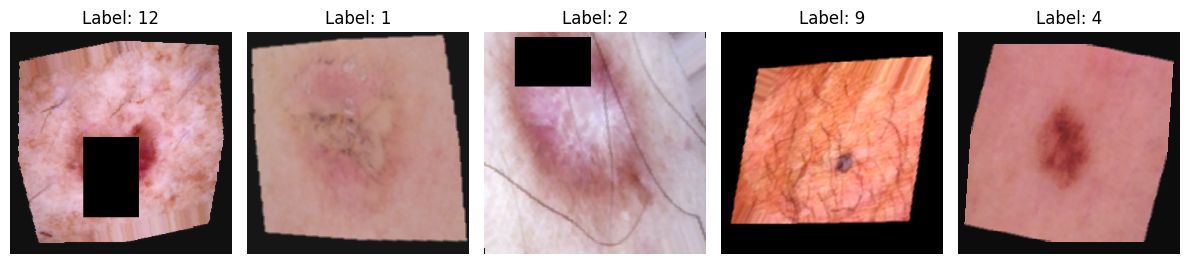

In [64]:
# Visualize 
def imshow(img_tensor):
    img = img_tensor * 0.5 + 0.5 
    np_img = img.permute(1, 2, 0).numpy()
    plt.imshow(np_img)
    plt.axis("off")

images, labels = next(iter(train_loader))
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(images[i])
    plt.title(f"Label: {labels[i].item()}")
plt.tight_layout()
plt.show()


In [70]:
# cnn Model
import torch.nn as nn
import torch.nn.functional as F
class SkinCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 13)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [74]:
# Instantiate model and (SWA model) :weights ka average leke generalization improve karta hai — especially jab model overfit hone lagta hai ya training unstable ho. 
from torch.optim.swa_utils import AveragedModel, SWALR  # Added for SWA
model = SkinCNN().to(device)
swa_model = AveragedModel(model)  # Create SWA version of the model

# Evaluation Function
def evaluate(model, loader, criterion):
    model.eval()
    total, correct, val_loss = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return val_loss / len(loader), (100 * correct / total)

In [76]:
# Evaluation Function
def evaluate(model, loader, criterion):
    model.eval()
    total, correct, val_loss = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return val_loss / len(loader), (100 * correct / total)


In [84]:
# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4)
swa_start = 20  # Start SWA after 20 epochs
swa_scheduler = SWALR(optimizer, swa_lr=0.0001)  # SWA learning rate


In [86]:
# Train model
best_acc = 0
early_stop, patience = 0, 7
epochs = 60

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Update SWA model after swa_start epochs
    if epoch >= swa_start:
        swa_model.update_parameters(model)
        swa_scheduler.step()
    else:
        # Regular scheduler step before SWA starts
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        scheduler.step(val_acc)

    val_loss, val_acc = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}, Val_Loss: {val_loss:.4f}, Val_Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        early_stop = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop += 1
        if early_stop >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/2 - Loss: 1.7029, Val_Loss: 1.4483, Val_Acc: 50.94%
Epoch 2/2 - Loss: 1.4115, Val_Loss: 1.2792, Val_Acc: 56.19%


In [90]:
class_names = train_dataset.classes
submission = []

for i, img_name in enumerate(sorted(os.listdir(test_dir))):
    img_path = os.path.join(test_dir, img_name)
    img = Image.open(img_path).convert("RGB")
    input_tensor = test_transforms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
        pred_label = class_names[pred]

    image_id = img_name.split('.')[0]
    submission.append({"id": image_id, "Prediction": pred_label})

df = pd.DataFrame(submission)
df.to_csv("submissions.csv", index=False)
print("Submission file saved as 'submissions.csv'")

Submission file saved as 'submissions.csv'
